In [1]:

import torch
import config
from lite_module import MyDataModule, LitYoloV3
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning import LightningModule, Trainer, seed_everything
seed_everything(7)

D:\Anaconda\envs\py3\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
Global seed set to 7


7

In [2]:
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)

In [3]:
pascal_dm = MyDataModule()


In [4]:
from model import YOLOv3
from loss import YoloLoss
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

In [5]:
model = LitYoloV3()

trainer = Trainer(
    max_epochs=40,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
pascal_dm.setup("train")
train_loader = pascal_dm.train_dataloader()

In [ ]:
lr_finder = trainer.tuner.lr_find(model, train_loader, num_training = 100, max_lr = 10)

C:\Users\H504171\AppData\Local\Temp\ipykernel_31652\2355603538.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


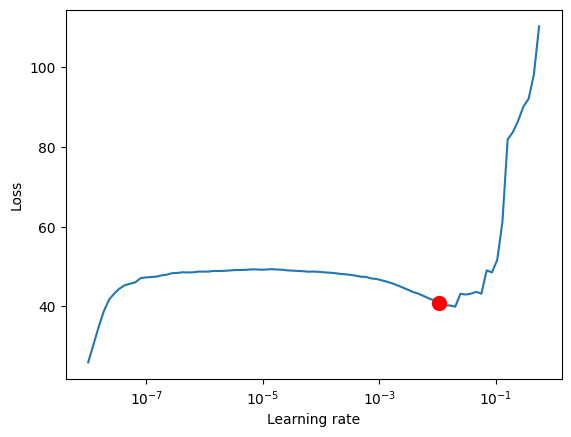

In [29]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

In [7]:
model = LitResnet()

trainer = Trainer(
    max_epochs=40,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="./logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)


trainer.fit(model, pascal_dm)
trainer.test(model, pascal_dm)

#Trained with S13.py on nohup and the logs are taken from nohup.out
# with open(r"./nohup.out", "r", encoding="utf-8")as f:
#     r = f.read()
# print(r)

Global seed set to 7
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | YOLOv3 | 61.6 M
---------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
123.253   Total estimated model params size (MB)

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]Traceback (most recent call last):
Global seed set to 7
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
----

In [7]:
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)

In [8]:
pascal_dm.setup("val")
val_dataloader = pascal_dm.val_dataloader()

In [9]:
from model import YOLOv3
model = YOLOv3(num_classes=20)
model.load_state_dict(torch.load(r"D:\Personal\Notebooks\S13\Models\model_40.pth", map_location=torch.device('cpu')))
model.eval()

YOLOv3(
  (layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (1): CNNBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): CNNBlock(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (leaky): LeakyReLU(negative_slope=0.1)
          )
          (1): CNNBlock(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [ ]:
check_class_accuracy(model, val_dataloader, threshold=config.CONF_THRESHOLD)

  1%|█                                                                               | 2/155 [02:22<2:57:54, 69.77s/it]

In [ ]:
pred_boxes, true_boxes = get_evaluation_bboxes(
            val_dataloader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
            device="cpu",
        )
mapval = mean_average_precision(
    pred_boxes,
    true_boxes,
    iou_threshold=config.MAP_IOU_THRESH,
    box_format="midpoint",
    num_classes=config.NUM_CLASSES,
)
print(f"MAP: {mapval.item()}")